In [40]:
import matplotlib.pyplot as plt
import numpy as np

# Plot of $b$ Coefficients for All Kernels

This notebook visualizes the $b$ coefficients from all JSON files in the `data` directory. For each kernel, the $b$ values (exponentiated, as they are stored in log form) are plotted on the x-axis (log scale), and the number of coefficients is on the y-axis. Each kernel is shown in a separate subplot, arranged in a grid with 2 columns. No legends are included.

In [41]:
import os
import json
import numpy as np
import matplotlib.pyplot as plt

In [42]:
# Load b coefficients from all JSON files in data directory (grouped by top-level entry)
# Also compute initial guesses for N >= 3 using the last two b vectors and ratios for N >= 4

def initial_guess_b(b_old, b_old_old, ratios=None):
    import numpy as np
    if ratios is None:
        ratios = np.array([0.5])
    else:
        ratios = np.hstack((ratios, np.array(ratios[-1])))
    new_start = b_old[0] + (b_old[0] - b_old_old[0])
    new_end = b_old[-1] + (b_old[-1] - b_old_old[-1])
    new_mid = b_old[:-1] * ratios + b_old[1:] * (1 - ratios)
    b_new = np.concatenate(([new_start], new_mid, [new_end]))
    return b_new

import os
import json
import numpy as np

data_dir = 'data'
kernel_files = [f for f in os.listdir(data_dir) if f.endswith('.json')]
kernel_b_coeffs = {}
kernel_b_initial_guesses = {}

for fname in kernel_files:
    with open(os.path.join(data_dir, fname), 'r') as f:
        data = json.load(f)
        # Sort entries by key (as int)
        sorted_items = sorted(data.items(), key=lambda x: int(x[0]))
        entry_b = {}
        entry_b_init = {}
        b_list = []
        entry_keys = []
        for entry_key, entry in sorted_items:
            b = entry.get('b', None)
            if b is not None:
                b_arr = np.array(b)
                b_exp = np.exp(b_arr)
                entry_b[entry_key] = b_exp
                b_list.append(b_arr)
                entry_keys.append(entry_key)
        # Compute initial guesses for N >= 3
        ratios = None
        for i in range(2, len(b_list)):
            b_old = b_list[i-1]
            b_old_old = b_list[i-2]
            if i >= 3:
                # Compute ratios as in kernel_fit.py
                ratios = (b_list[i-1][1:-1] - b_list[i-2][1:]) / (b_list[i-2][:-1] - b_list[i-2][1:])
            b_init = initial_guess_b(b_old, b_old_old, ratios=ratios)
            b_init_exp = np.exp(b_init)
            entry_b_init[entry_keys[i]] = b_init_exp
        if entry_b:
            kernel_b_coeffs[fname.replace('.json', '')] = entry_b
        if entry_b_init:
            kernel_b_initial_guesses[fname.replace('.json', '')] = entry_b_init

kernel_b_coeffs, kernel_b_initial_guesses

({'exp_squared': {'1': array([0.36787944])},
  'matern': {'1': array([0.56503929]),
   '2': array([0.40815858, 1.58581428]),
   '3': array([0.35261801, 1.06428126, 4.06093687]),
   '4': array([0.32187965, 0.8700666 , 2.52991377, 9.21450461]),
   '5': array([ 0.30156841,  0.76375067,  1.97078864,  5.39177309, 18.95998993]),
   '6': array([ 0.28679806,  0.69474217,  1.67225144,  4.03130951, 10.5105983 ,
          36.29526163])},
  'cauchy': {'1': array([0.29719101]),
   '2': array([0.15991175, 5.14572301]),
   '3': array([ 0.11920422,  2.26649916, 30.4226197 ]),
   '4': array([9.90037676e-02, 1.55301840e+00, 1.09915463e+01, 1.35048949e+02]),
   '5': array([8.63955699e-02, 1.22799751e+00, 6.63452319e+00, 4.12199269e+01,
          5.01257597e+02]),
   '6': array([7.76004074e-02, 1.03914163e+00, 4.83421207e+00, 2.21365054e+01,
          1.34737851e+02, 1.63673303e+03]),
   '7': array([7.10413082e-02, 9.14046179e-01, 3.87118289e+00, 1.48185290e+01,
          6.57751371e+01, 3.99086291e+02, 4

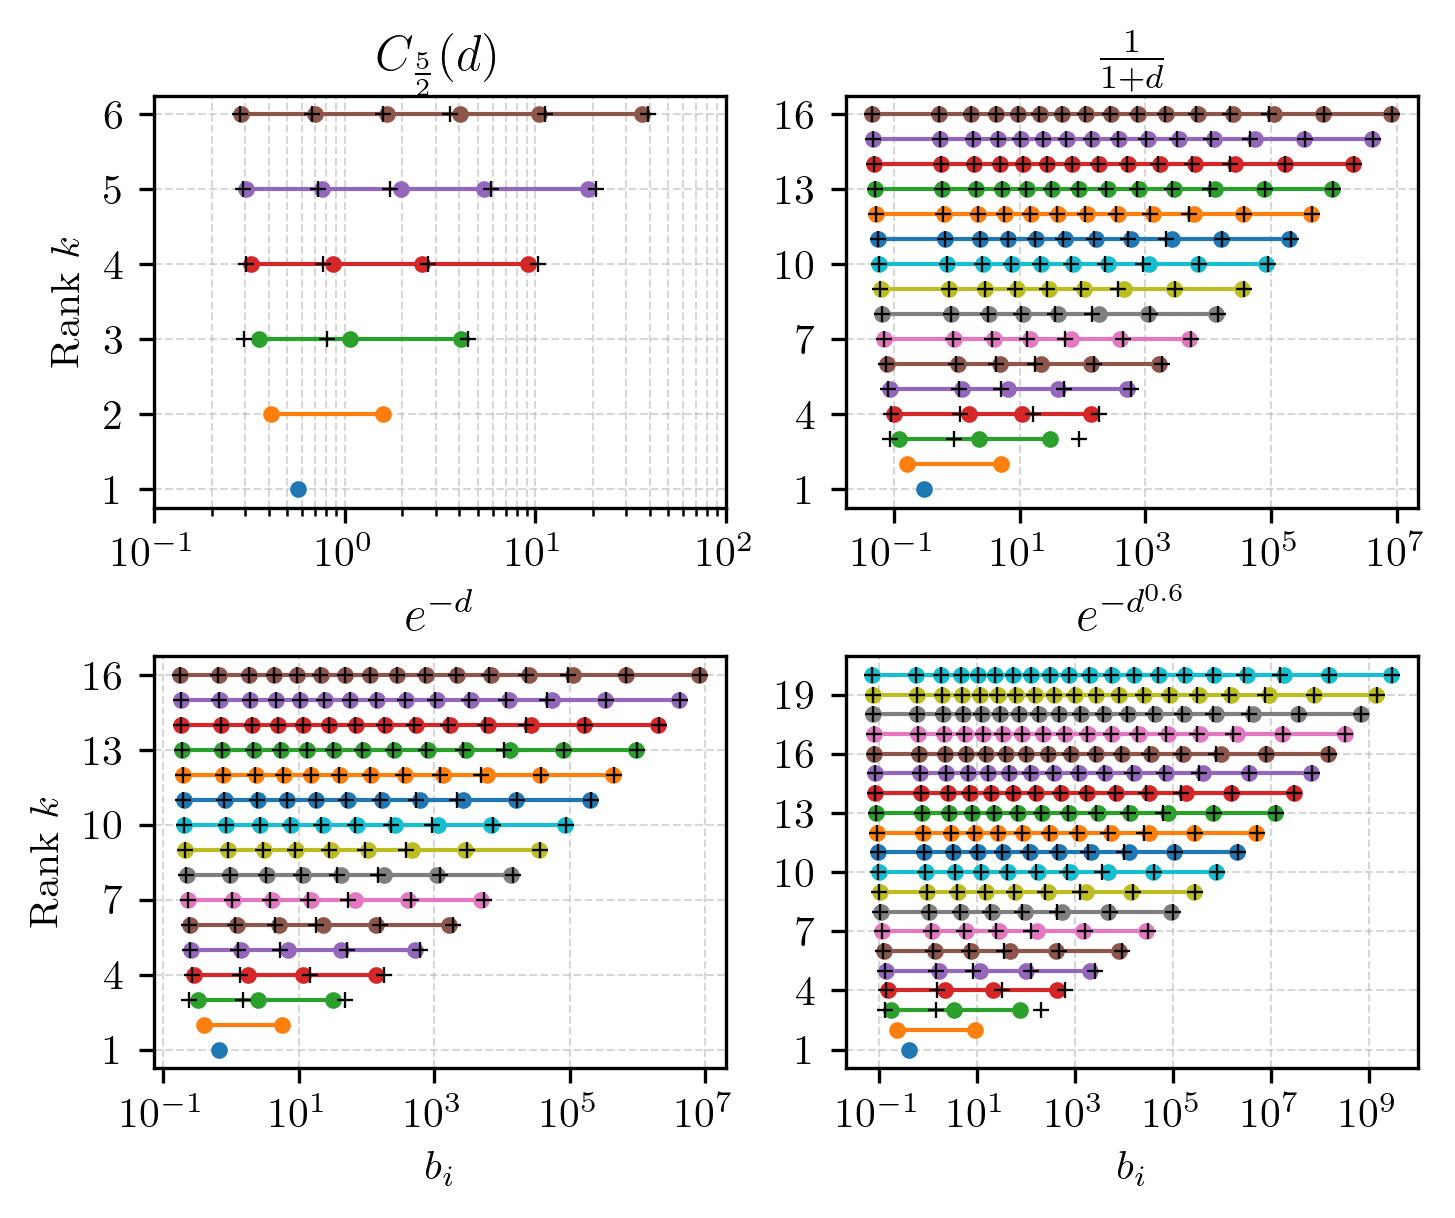

In [73]:
# Plotting: filter out rq and exp_squared, update axis labels, use LaTeX titles, and set rcParams
plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.size": 10,
    "axes.labelsize": 10,
    "legend.fontsize": 10,
    "xtick.labelsize": 10,
    "ytick.labelsize": 10,
})

# Map kernel file names to LaTeX titles
cov_dict = {
    "exp": r"$e^{-d}$",
    "cauchy": r"$\frac{1}{1+d}$",
    "powexp06": r"$e^{-d^{0.6}}$",
    "matern": r"$C_{\frac{5}{2}}(d)$",
    # "rq": r"$\\left(1 + \\frac{d^2}{2}\\right)^{-1}$",  # excluded
    # "exp_squared": r"$e^{-d^2}$",  # excluded
}

# Filter kernels
filtered_kernels = [k for k in kernel_b_coeffs if k in cov_dict]
num_kernels = len(filtered_kernels)
cols = 2
rows = (num_kernels + 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(4.8, 4), dpi=300)
axes = np.array(axes).reshape(rows, cols)

for idx, kernel in enumerate(filtered_kernels):
    row, col = idx // cols, idx % cols
    ax = axes[row, col]
    entry_b_dict = kernel_b_coeffs[kernel]
    entry_b_init_dict = kernel_b_initial_guesses.get(kernel, {})
    for entry_key, b_vals in entry_b_dict.items():
        n_coeffs = len(b_vals)
        y = np.ones_like(b_vals) * n_coeffs  # constant y value = number of coefficients
        ax.plot(b_vals, y, marker='o', markersize=3, label=entry_key, linewidth=1.0)
        # Plot initial guesses if present
        b_init_vals = entry_b_init_dict.get(entry_key)
        if b_init_vals is not None:
            y_init = np.ones_like(b_init_vals) * n_coeffs
            ax.plot(
                b_init_vals,
                y_init,
                linestyle='None',
                marker='+',
                markersize=4,
                color='black',
                linewidth=0.25,
                markeredgewidth=0.55)

    # Remove y labels on right column
    if col == cols - 1:
        ax.set_ylabel("")
        # ax.yaxis.set_ticklabels([])
    else:
        ax.set_ylabel(r"Rank $k$")
    # Remove x labels on upper row
    if row == 0:
        ax.set_xlabel("")
        # ax.xaxis.set_ticklabels([])
    else:
        ax.set_xlabel(r"$b_i$")
    ax.set_title(cov_dict[kernel])
    ax.grid(True, which='both', ls='--', alpha=0.5, linewidth=0.5)
    ax.set_xscale('log')

    if len(entry_b_dict.items()) < 7:
        ax.set_yticks(np.arange(1, 7))
        ax.set_yticklabels([str(i) for i in range(1, 7)])
        ax.set_xticks([0.1, 1, 10, 100])
        ax.set_xticklabels([r"$10^{-1}$", r"$10^{0}$", r"$10^{1}$", r"$10^{2}$"])
    elif len(entry_b_dict.items()) < 17:
        ax.set_yticks(np.arange(1, 17,3))
        ax.set_yticklabels([str(i) for i in range(1, 17,3)])
        ax.set_xticks([0.1, 10, 1000, 100000, 10000000])
        ax.set_xticklabels([r"$10^{-1}$", r"$10^{1}$", r"$10^{3}$", r"$10^{5}$", r"$10^{7}$"])
    else:
        ax.set_yticks(np.arange(1, 21,3))
        ax.set_yticklabels([str(i) for i in range(1, 21,3)])
        ax.set_xticks([0.1, 10, 1000, 100000, 10000000, 1000000000])
        ax.set_xticklabels([r"$10^{-1}$", r"$10^{1}$", r"$10^{3}$", r"$10^{5}$", r"$10^{7}$", r"$10^{9}$"])

# Hide any unused subplots
for i in range(num_kernels, rows * cols):
    fig.delaxes(axes[i // cols, i % cols])

plt.tight_layout(pad=0.5, w_pad=0.5, h_pad=0.5)
fig.savefig("b_coefficients_all_kernels.pdf", bbox_inches='tight', pad_inches=0)
plt.show()